# ** Fruit 360 **

We'll work with the [Fruit 360 dataset](https://www.kaggle.com/datasets/moltean/fruits) from Kaggle.

This is image data of fruits and vegetables. It contains around 90k images of size 100x100 distributed under 131 categories.
The Train and Test data is separated. There are around 68k images in Train and 23k in Test.

In [ ]:
import os
import pathlib

from tqdm import tqdm
import itertools
import cv2

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn; sn.set(font_scale=1.4)

import tensorflow as tf
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, LeakyReLU, Dropout, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.python.ops.gen_math_ops import arg_max
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(6)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.xlabel("epochs")
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower left')
  plt.xlabel("epochs")
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [ ]:
def print_mislabeled_images(class_names, test_data, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """

    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_data[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of mislabeled images by the classifier", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[mislabeled_labels[i]])
    plt.show()

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):

  # Create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize our confusion matrix
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Set labels to be classes
  if classes!=[]:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted Label",
        ylabel="True Label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Import and preprocess the data

## Import the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/Fruits 360 - 20 classes".zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: Training/Pomegranate/316_100.jpg  
  inflating: Training/Pomegranate/317_100.jpg  
  inflating: Training/Pomegranate/318_100.jpg  
  inflating: Training/Pomegranate/319_100.jpg  
  inflating: Training/Pomegranate/31_100.jpg  
  inflating: Training/Pomegranate/320_100.jpg  
  inflating: Training/Pomegranate/r_0_100.jpg  
  inflating: Training/Pomegranate/r_100_100.jpg  
  inflating: Training/Pomegranate/r_101_100.jpg  
  inflating: Training/Pomegranate/r_102_100.jpg  
  inflating: Training/Pomegranate/r_103_100.jpg  
  inflating: Training/Pomegranate/r_104_100.jpg  
  inflating: Training/Pomegranate/r_105_100.jpg  
  inflating: Training/Pomegranate/r_106_100.jpg  
  inflating: Training/Pomegranate/r_107_100.jpg  
  inflating: Training/Pomegranate/r_108_100.jpg  
  inflating: Training/Pomegranate/r_109_100.jpg  
  inflating: Training/Pomegranate/r_110_100.jpg  
  inflating: Training/Pomegranate/r_111_100.jpg  
  inflatin

> 🔑 **Note:** If you're using Google Colab and your runtime disconnects, you may have to redownload the files. You can do this by rerunning the cell above.

## Overview the data structure

`ls` stands for list.

In [ ]:
!ls

drive  sample_data  Test  Training


In [ ]:
!ls "Training"

'Apple Granny Smith'   Blueberry	   Guava       Orange	   Pomegranate
'Apple Red 1'	      'Cherry Wax Black'   Kiwi        Peach	   Quince
 Apricot	      'Grapefruit Pink'    Mandarine   Pear	   Strawberry
 Banana		      'Grape White'	   Mango       Pineapple   Watermelon


In [ ]:
train_dir = "Training"
test_dir = "Test"

In [ ]:
# Walk through train directory and list number of files
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

NameError: ignored

In [ ]:
# Another way to find out how many images are in a file
num_specific_class_train = len(os.listdir(train_dir))
num_specific_class_train

20

In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Apple Granny Smith' 'Apple Red 1' 'Apricot' 'Banana' 'Blueberry'
 'Cherry Wax Black' 'Grape White' 'Grapefruit Pink' 'Guava' 'Kiwi'
 'Mandarine' 'Mango' 'Orange' 'Peach' 'Pear' 'Pineapple' 'Pomegranate'
 'Quince' 'Strawberry' 'Watermelon']


In [ ]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (100, 100)
INPUT_TENSOR = (100, 100, 3)

## Load the data

In [ ]:
def load_data():
    """
        Load the data:
            - 9,738 images to train the network.
            - 3,267 images to test how accurately the network learned to classify images.
    """

    datasets = [train_dir, test_dir]
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        images = images / 255.0

        output.append((images, labels))

    return output

In [ ]:
(train_data, train_labels), (test_data, test_labels) = load_data()

Loading Training


100%|██████████| 492/492 [00:00<00:00, 3996.63it/s]


Loading Test


100%|██████████| 164/164 [00:00<00:00, 2749.31it/s]


In [ ]:
tf.random.set_seed(42)
train_data, train_labels = shuffle(train_data, train_labels, random_state=427)

## Analyze the data

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 9738
Number of testing examples: 3267
Each image is of size: (100, 100)


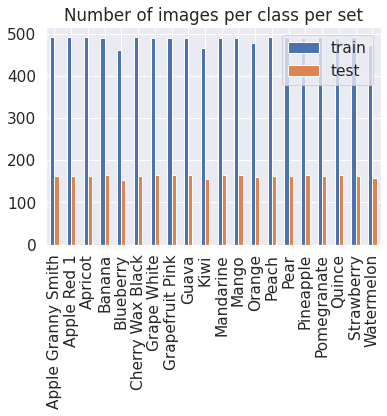

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.title("Number of images per class per set")
plt.show()

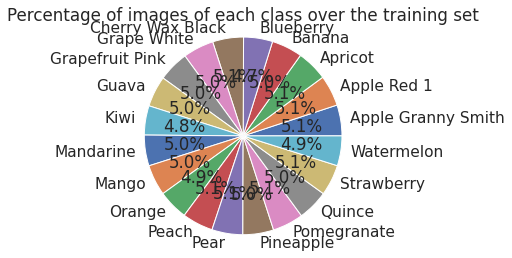

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Percentage of images of each class over the training set')
plt.show()

## Visualize the data

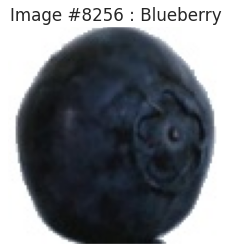

In [ ]:
display_random_image(class_names, train_data, train_labels)

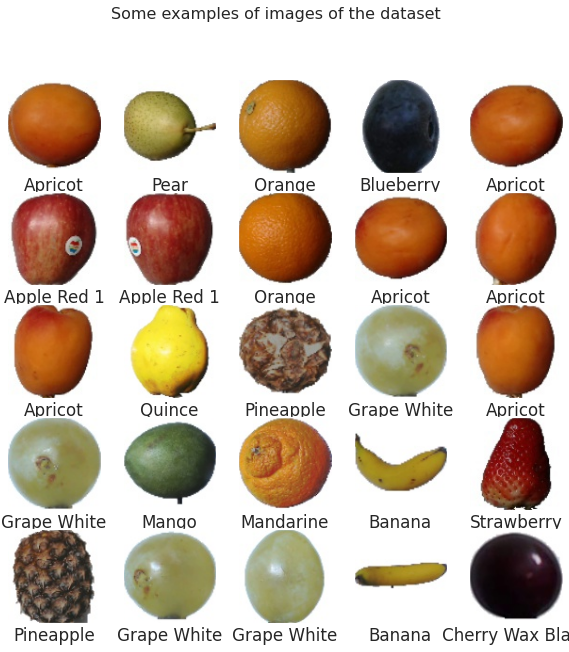

In [ ]:
display_examples(class_names, train_data, train_labels)

# Create, train, evaluate basic models

## FCNN (model_FC)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_FC = Sequential([
  Flatten(),
  Dense(100),
  Activation('relu'),
  Dense(50),
  Activation('relu'),
  Dense(20), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_FC.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_FC = model_FC.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/6
244/244 [==============================] - 8s 9ms/step - loss: 3.2556 - accuracy: 0.0570 - val_loss: 2.9962 - val_accuracy: 0.0447
Epoch 2/6
244/244 [==============================] - 1s 6ms/step - loss: 2.9958 - accuracy: 0.0465 - val_loss: 2.9966 - val_accuracy: 0.0447
Epoch 3/6
244/244 [==============================] - 1s 6ms/step - loss: 2.9957 - accuracy: 0.0520 - val_loss: 2.9969 - val_accuracy: 0.0447
Epoch 4/6
244/244 [==============================] - 1s 6ms/step - loss: 2.9957 - accuracy: 0.0476 - val_loss: 2.9971 - val_accuracy: 0.0447
Epoch 5/6
244/244 [==============================] - 1s 6ms/step - loss: 2.9956 - accuracy: 0.0520 - val_loss: 2.9974 - val_accuracy: 0.0447
Epoch 6/6
244/244 [==============================] - 1s 6ms/step - loss: 2.9956 - accuracy: 0.0501 - val_loss: 2.9976 - val_accuracy: 0.0447


In [ ]:
model_FC.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 100)               3000100   
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 activation_2 (Activation)   (None, 20)                0

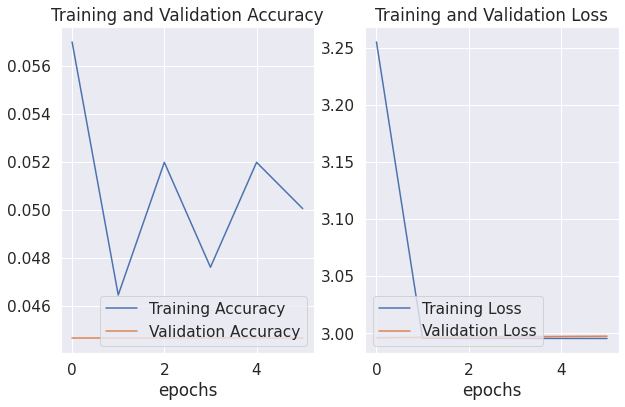

In [ ]:
plot_accuracy_loss(history_FC)

## CNN (model_C)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_C = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(20), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_C.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_C = model_C.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/6
244/244 [==============================] - 12s 13ms/step - loss: 0.4639 - accuracy: 0.8608 - val_loss: 0.0068 - val_accuracy: 0.9995
Epoch 2/6
244/244 [==============================] - 2s 10ms/step - loss: 0.0468 - accuracy: 0.9896 - val_loss: 7.8721e-04 - val_accuracy: 1.0000
Epoch 3/6
244/244 [==============================] - 2s 10ms/step - loss: 5.0814e-04 - accuracy: 1.0000 - val_loss: 2.5678e-04 - val_accuracy: 1.0000
Epoch 4/6
244/244 [==============================] - 3s 11ms/step - loss: 1.9301e-04 - accuracy: 1.0000 - val_loss: 1.6294e-04 - val_accuracy: 1.0000
Epoch 5/6
244/244 [==============================] - 3s 13ms/step - loss: 1.1575e-04 - accuracy: 1.0000 - val_loss: 8.7384e-05 - val_accuracy: 1.0000
Epoch 6/6
244/244 [==============================] - 2s 10ms/step - loss: 7.3067e-05 - accuracy: 1.0000 - val_loss: 6.5732e-05 - val_accuracy: 1.0000


In [ ]:
model_C.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 activation_3 (Activation)   (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 activation_4 (Activation)   (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

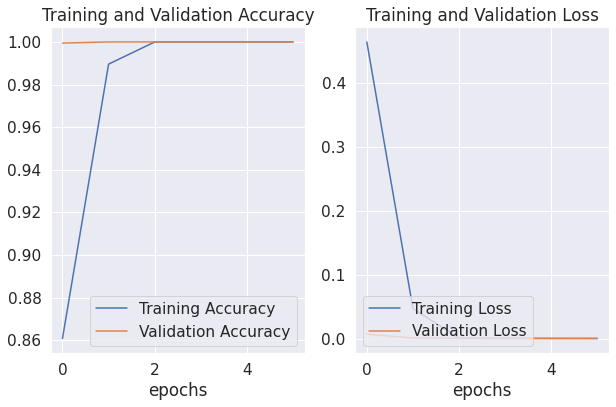

In [ ]:
plot_accuracy_loss(history_C)

## First results' and errors' analysis

In [ ]:
test_loss_FC = model_FC.evaluate(test_data, test_labels)

103/103 [==============================] - 0s 4ms/step - loss: 2.9956 - accuracy: 0.0502


In [ ]:
test_loss_C = model_C.evaluate(test_data, test_labels)

103/103 [==============================] - 1s 7ms/step - loss: 0.0035 - accuracy: 0.9991


103/103 [==============================] - 1s 6ms/step


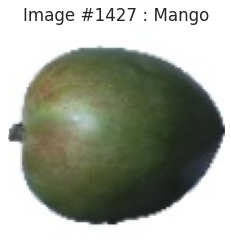

In [ ]:
# Using CNN for predictions

predictions = model_C.predict(test_data)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_data, pred_labels)

IndexError: ignored

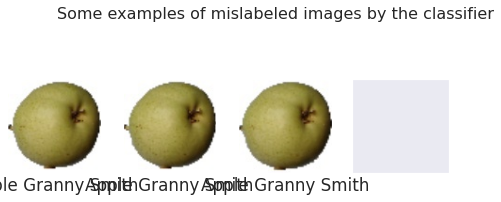

In [ ]:
print_mislabeled_images(class_names, test_data, test_labels, pred_labels)

<ipython-input-6-7aca80be51b6>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if classes!=[]:


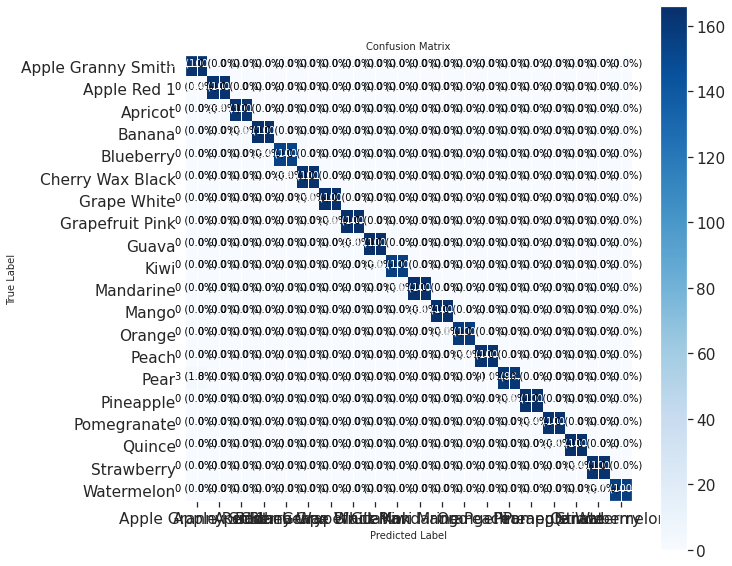

In [ ]:
make_confusion_matrix(y_true=test_labels, y_pred=pred_labels, classes=class_names, figsize=(10, 10), text_size=10)

# Experimenting vol.1 based on model_C

## Increasing number of parameters (model_1)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_1 = Sequential([
  Conv2D(32, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_1 = model_1.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/6
244/244 [==============================] - 7s 19ms/step - loss: 0.3122 - accuracy: 0.9068 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/6
244/244 [==============================] - 4s 16ms/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 4.6527e-04 - val_accuracy: 1.0000
Epoch 3/6
244/244 [==============================] - 4s 16ms/step - loss: 1.6114e-04 - accuracy: 1.0000 - val_loss: 3.6039e-04 - val_accuracy: 1.0000
Epoch 4/6
244/244 [==============================] - 4s 15ms/step - loss: 7.5686e-05 - accuracy: 1.0000 - val_loss: 3.8275e-04 - val_accuracy: 1.0000
Epoch 5/6
244/244 [==============================] - 4s 17ms/step - loss: 4.5145e-05 - accuracy: 1.0000 - val_loss: 3.4592e-04 - val_accuracy: 1.0000
Epoch 6/6
244/244 [==============================] - 4s 16ms/step - loss: 2.9148e-05 - accuracy: 1.0000 - val_loss: 3.9825e-04 - val_accuracy: 0.9995


In [ ]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                  

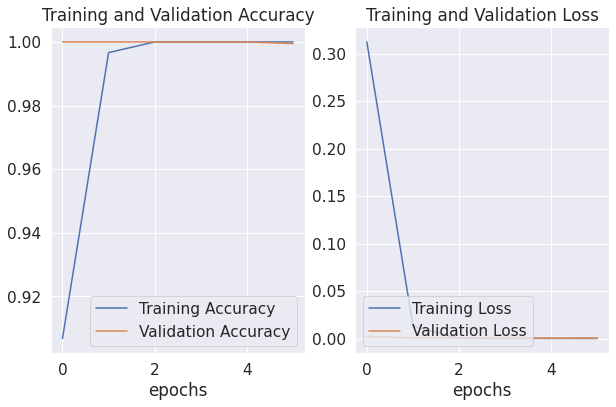

In [ ]:
plot_accuracy_loss(history_1)

## Adding 1 convolutional and 1 dense layer (model_2)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_2 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_2 = model_2.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/6
244/244 [==============================] - 7s 13ms/step - loss: 0.6373 - accuracy: 0.7918 - val_loss: 0.0222 - val_accuracy: 0.9954
Epoch 2/6
244/244 [==============================] - 2s 10ms/step - loss: 0.0212 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 0.9995
Epoch 3/6
244/244 [==============================] - 3s 10ms/step - loss: 0.0569 - accuracy: 0.9837 - val_loss: 0.0041 - val_accuracy: 0.9995
Epoch 4/6
244/244 [==============================] - 3s 11ms/step - loss: 4.7751e-04 - accuracy: 1.0000 - val_loss: 6.1436e-04 - val_accuracy: 1.0000
Epoch 5/6
244/244 [==============================] - 3s 13ms/step - loss: 1.4642e-04 - accuracy: 1.0000 - val_loss: 6.3862e-04 - val_accuracy: 0.9995
Epoch 6/6
244/244 [==============================] - 3s 10ms/step - loss: 8.4753e-05 - accuracy: 1.0000 - val_loss: 5.9005e-04 - val_accuracy: 0.9995


In [ ]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 activation_13 (Activation)  (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 activation_14 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

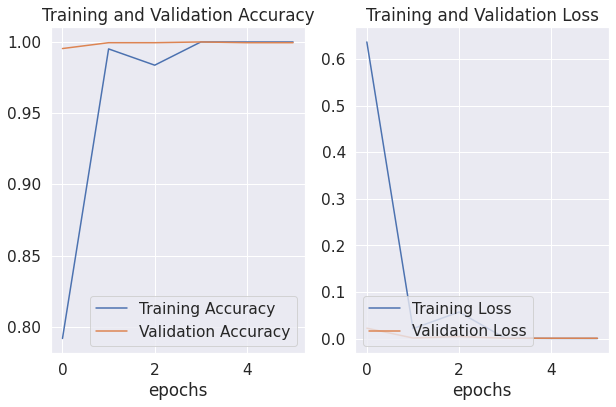

In [ ]:
plot_accuracy_loss(history_2)

## Adding 2 convolutional and 2 dense layers (model_3)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_3 = Sequential([
  Conv2D(8, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(60),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/6
244/244 [==============================] - 7s 17ms/step - loss: 1.0010 - accuracy: 0.6515 - val_loss: 0.1531 - val_accuracy: 0.9666
Epoch 2/6
244/244 [==============================] - 3s 10ms/step - loss: 0.1203 - accuracy: 0.9593 - val_loss: 0.0240 - val_accuracy: 0.9918
Epoch 3/6
244/244 [==============================] - 2s 10ms/step - loss: 0.0470 - accuracy: 0.9845 - val_loss: 0.0369 - val_accuracy: 0.9877
Epoch 4/6
244/244 [==============================] - 2s 10ms/step - loss: 0.0647 - accuracy: 0.9804 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/6
244/244 [==============================] - 2s 10ms/step - loss: 7.4162e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 6/6
244/244 [==============================] - 3s 13ms/step - loss: 0.0063 - accuracy: 0.9987 - val_loss: 2.1050e-04 - val_accuracy: 1.0000


In [ ]:
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 100, 8)       224       
                                                                 
 activation_20 (Activation)  (None, 100, 100, 8)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 50, 50, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 16)        1168      
                                                                 
 activation_21 (Activation)  (None, 50, 50, 16)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 25, 25, 16)       0         
 g2D)                                                 

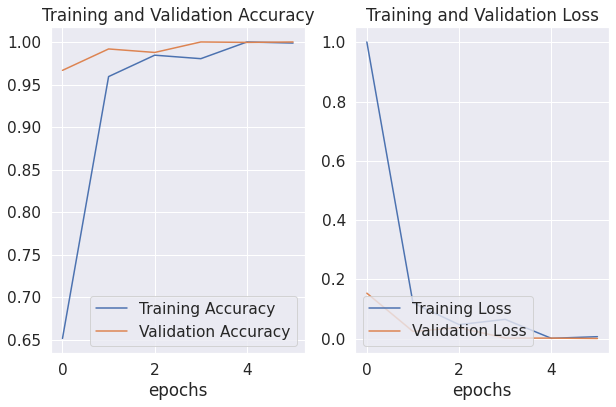

In [ ]:
plot_accuracy_loss(history_3)

## Decreasing number of parameters (model_4)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_4 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(60),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_4 = model_4.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/6
244/244 [==============================] - 4s 12ms/step - loss: 0.6613 - accuracy: 0.8040 - val_loss: 0.0295 - val_accuracy: 0.9933
Epoch 2/6
244/244 [==============================] - 2s 9ms/step - loss: 0.0230 - accuracy: 0.9937 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 3/6
244/244 [==============================] - 3s 12ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 5.9600e-04 - val_accuracy: 1.0000
Epoch 4/6
244/244 [==============================] - 3s 10ms/step - loss: 3.9594e-04 - accuracy: 1.0000 - val_loss: 3.7246e-04 - val_accuracy: 1.0000
Epoch 5/6
244/244 [==============================] - 2s 9ms/step - loss: 2.4950e-04 - accuracy: 1.0000 - val_loss: 2.4877e-04 - val_accuracy: 1.0000
Epoch 6/6
244/244 [==============================] - 2s 9ms/step - loss: 1.6927e-04 - accuracy: 1.0000 - val_loss: 1.9907e-04 - val_accuracy: 1.0000


In [ ]:
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 activation_29 (Activation)  (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 activation_30 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                 

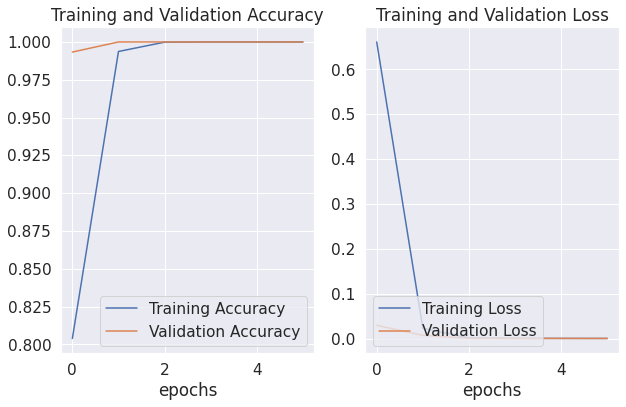

In [ ]:
plot_accuracy_loss(history_4)

## Removing 1 convolutional layer (model_5)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_5 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_5 = model_5.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/6
244/244 [==============================] - 5s 13ms/step - loss: 0.3232 - accuracy: 0.9109 - val_loss: 0.0094 - val_accuracy: 0.9990
Epoch 2/6
244/244 [==============================] - 2s 10ms/step - loss: 0.0115 - accuracy: 0.9976 - val_loss: 9.8095e-04 - val_accuracy: 1.0000
Epoch 3/6
244/244 [==============================] - 2s 9ms/step - loss: 4.9416e-04 - accuracy: 1.0000 - val_loss: 5.0555e-04 - val_accuracy: 1.0000
Epoch 4/6
244/244 [==============================] - 2s 8ms/step - loss: 2.3569e-04 - accuracy: 1.0000 - val_loss: 2.6038e-04 - val_accuracy: 1.0000
Epoch 5/6
244/244 [==============================] - 2s 9ms/step - loss: 1.2657e-04 - accuracy: 1.0000 - val_loss: 2.5509e-04 - val_accuracy: 1.0000
Epoch 6/6
244/244 [==============================] - 2s 8ms/step - loss: 6.6667e-05 - accuracy: 1.0000 - val_loss: 1.1225e-04 - val_accuracy: 1.0000


In [ ]:
model_5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 activation_34 (Activation)  (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 activation_35 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                 

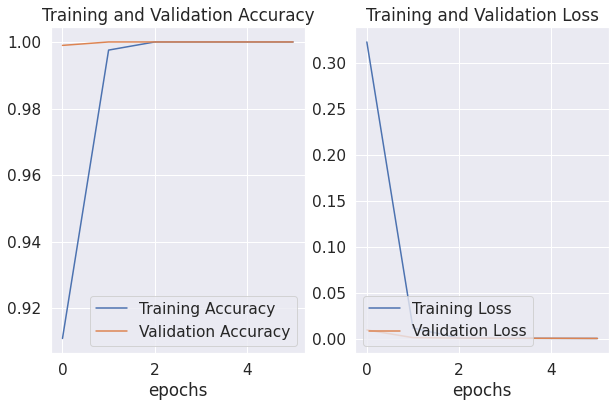

In [ ]:
plot_accuracy_loss(history_5)

## Comparing our models' accuracies so far vol.1

In [ ]:
mfc = max(history_FC.history['val_accuracy'])
mc = max(history_C.history['val_accuracy'])
m1 = max(history_1.history['val_accuracy'])
m2 = max(history_2.history['val_accuracy'])
m3 = max(history_3.history['val_accuracy'])
m4 = max(history_4.history['val_accuracy'])
m5 = max(history_5.history['val_accuracy'])

model_results_1 = [["model_FC", mfc],
                 ["model_C", mc],
                 ["model_1", m1],
                 ["model_2", m2],
                 ["model_3", m3],
                 ["model_4", m4],
                 ["model_5", m5]]

In [ ]:
# Let's compare our model's results using a pandas DataFrame
all_results_1 = pd.DataFrame(model_results_1, columns=["model", "val_accuracy"])
all_results_1

,model,val_accuracy
0,model_FC,0.044661
1,model_C,1.000000
2,model_1,1.000000
3,model_2,1.000000
4,model_3,1.000000
5,model_4,1.000000
6,model_5,1.000000


# Experimenting vol. 2 based on model_2

## Changing activation function to LeakyReLU (model_6)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_6 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  LeakyReLU(alpha=0.2),
  Dense(120),
  LeakyReLU(alpha=0.2),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_6 = model_6.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 16s 13ms/step - loss: 0.9924 - accuracy: 0.6140 - val_loss: 0.7760 - val_accuracy: 0.7114
Epoch 2/10
351/351 [==============================] - 4s 11ms/step - loss: 0.6981 - accuracy: 0.7425 - val_loss: 0.6663 - val_accuracy: 0.7510
Epoch 3/10
351/351 [==============================] - 4s 10ms/step - loss: 0.5695 - accuracy: 0.7949 - val_loss: 0.5553 - val_accuracy: 0.7980
Epoch 4/10
351/351 [==============================] - 3s 9ms/step - loss: 0.4838 - accuracy: 0.8238 - val_loss: 0.5347 - val_accuracy: 0.8126
Epoch 5/10
351/351 [==============================] - 4s 10ms/step - loss: 0.3951 - accuracy: 0.8577 - val_loss: 0.5355 - val_accuracy: 0.8123
Epoch 6/10
351/351 [==============================] - 4s 11ms/step - loss: 0.3114 - accuracy: 0.8883 - val_loss: 0.5866 - val_accuracy: 0.8240
Epoch 7/10
351/351 [==============================] - 4s 13ms/step - loss: 0.2601 - accuracy: 0.9078 - val_loss: 0.6877 - val_accuracy: 0.7887

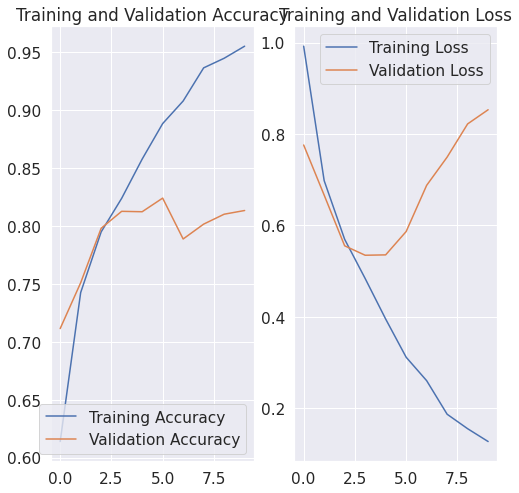

In [ ]:
plot_accuracy_loss(history_6)

## Changing optimizer to SGD (model_7)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_7 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_7.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

In [ ]:
history_7 = model_7.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 8s 17ms/step - loss: 1.5836 - accuracy: 0.3561 - val_loss: 1.6362 - val_accuracy: 0.3662
Epoch 2/10
351/351 [==============================] - 5s 14ms/step - loss: 1.1229 - accuracy: 0.5584 - val_loss: 1.0223 - val_accuracy: 0.5917
Epoch 3/10
351/351 [==============================] - 4s 11ms/step - loss: 1.0023 - accuracy: 0.6019 - val_loss: 1.0343 - val_accuracy: 0.5946
Epoch 4/10
351/351 [==============================] - 5s 14ms/step - loss: 0.9504 - accuracy: 0.6273 - val_loss: 0.9514 - val_accuracy: 0.6320
Epoch 5/10
351/351 [==============================] - 4s 11ms/step - loss: 0.9134 - accuracy: 0.6500 - val_loss: 0.9108 - val_accuracy: 0.6316
Epoch 6/10
351/351 [==============================] - 4s 13ms/step - loss: 0.8737 - accuracy: 0.6604 - val_loss: 0.9929 - val_accuracy: 0.6038
Epoch 7/10
351/351 [==============================] - 4s 12ms/step - loss: 0.8387 - accuracy: 0.6759 - val_loss: 0.8366 - val_accuracy: 0.6694

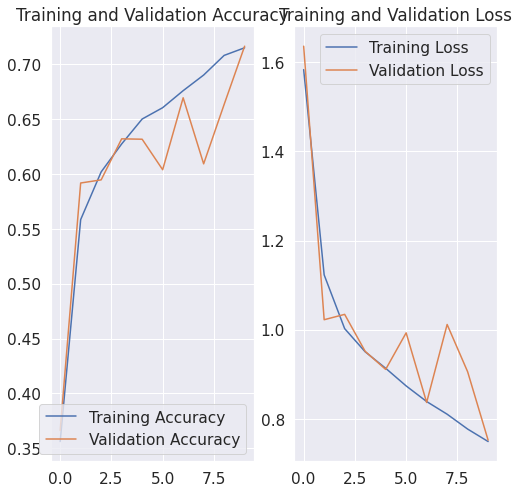

In [ ]:
plot_accuracy_loss(history_7)

## Changing optimizer to RMSprop (model_8)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_8 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_8.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=["accuracy"])

In [ ]:
history_8 = model_8.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 6s 12ms/step - loss: 1.1450 - accuracy: 0.5490 - val_loss: 0.9485 - val_accuracy: 0.6323
Epoch 2/10
351/351 [==============================] - 3s 9ms/step - loss: 0.8277 - accuracy: 0.6864 - val_loss: 0.7290 - val_accuracy: 0.7114
Epoch 3/10
351/351 [==============================] - 3s 9ms/step - loss: 0.6756 - accuracy: 0.7491 - val_loss: 0.6867 - val_accuracy: 0.7428
Epoch 4/10
351/351 [==============================] - 4s 10ms/step - loss: 0.5739 - accuracy: 0.7901 - val_loss: 0.5593 - val_accuracy: 0.7980
Epoch 5/10
351/351 [==============================] - 3s 9ms/step - loss: 0.4992 - accuracy: 0.8208 - val_loss: 0.5552 - val_accuracy: 0.8005
Epoch 6/10
351/351 [==============================] - 3s 9ms/step - loss: 0.4328 - accuracy: 0.8469 - val_loss: 0.7158 - val_accuracy: 0.7553
Epoch 7/10
351/351 [==============================] - 3s 10ms/step - loss: 0.3720 - accuracy: 0.8692 - val_loss: 0.5530 - val_accuracy: 0.8172
Epo

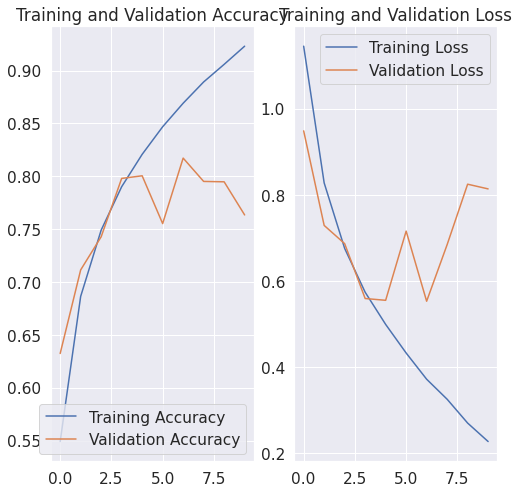

In [ ]:
plot_accuracy_loss(history_8)

## Plotting loss over learning rate (model_9)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_9 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_9.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create the learning rate callback
lr_scheduler_9 = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/20))

In [ ]:
history_9 = model_9.fit(train_data, train_labels, batch_size=32, epochs=80, validation_split = 0.2, callbacks=[lr_scheduler_9])

Epoch 1/80
351/351 [==============================] - 6s 11ms/step - loss: 1.6899 - accuracy: 0.3882 - val_loss: 1.5048 - val_accuracy: 0.4966 - lr: 1.0000e-05
Epoch 2/80
351/351 [==============================] - 4s 11ms/step - loss: 1.2943 - accuracy: 0.5343 - val_loss: 1.2079 - val_accuracy: 0.5308 - lr: 1.1220e-05
Epoch 3/80
351/351 [==============================] - 3s 9ms/step - loss: 1.1331 - accuracy: 0.5689 - val_loss: 1.1255 - val_accuracy: 0.5618 - lr: 1.2589e-05
Epoch 4/80
351/351 [==============================] - 3s 10ms/step - loss: 1.0551 - accuracy: 0.5985 - val_loss: 1.0646 - val_accuracy: 0.5907 - lr: 1.4125e-05
Epoch 5/80
351/351 [==============================] - 3s 10ms/step - loss: 1.0013 - accuracy: 0.6174 - val_loss: 1.0084 - val_accuracy: 0.6085 - lr: 1.5849e-05
Epoch 6/80
351/351 [==============================] - 3s 10ms/step - loss: 0.9575 - accuracy: 0.6381 - val_loss: 0.9637 - val_accuracy: 0.6306 - lr: 1.7783e-05
Epoch 7/80
351/351 [=====================

Text(0.5, 1.0, 'Finding the ideal learning rate')

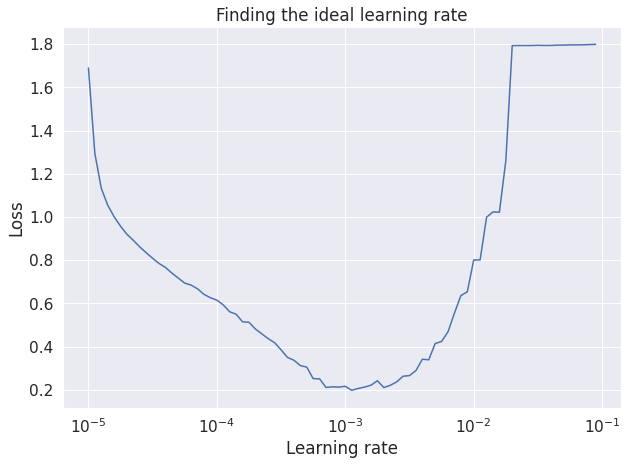

In [ ]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt

lrs = 1e-5 * (10**(tf.range(80)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_9.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate")

In [ ]:
def plot_accuracy_loss_2(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(80)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.xlabel("epochs")
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower left')
  plt.xlabel("epochs")
  plt.title('Training and Validation Loss')
  plt.show()

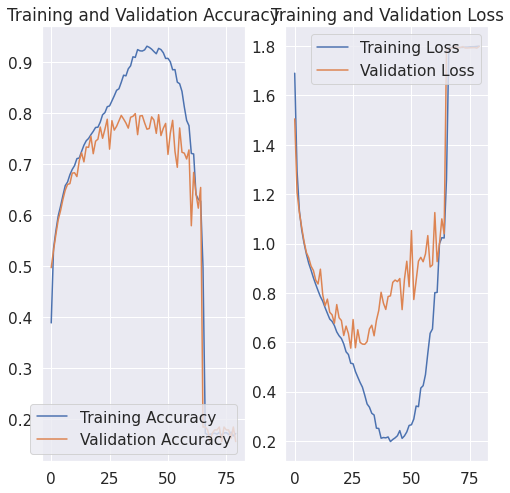

In [ ]:
plot_accuracy_loss_2(history_9)

## Changing learning rate to 6e-4 (model_10)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_10 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_10.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [ ]:
history_10 = model_10.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 6s 12ms/step - loss: 1.0228 - accuracy: 0.5973 - val_loss: 0.7896 - val_accuracy: 0.7018
Epoch 2/10
351/351 [==============================] - 3s 10ms/step - loss: 0.7244 - accuracy: 0.7332 - val_loss: 0.6438 - val_accuracy: 0.7613
Epoch 3/10
351/351 [==============================] - 3s 10ms/step - loss: 0.6001 - accuracy: 0.7812 - val_loss: 0.5562 - val_accuracy: 0.7966
Epoch 4/10
351/351 [==============================] - 4s 10ms/step - loss: 0.5141 - accuracy: 0.8129 - val_loss: 0.5162 - val_accuracy: 0.8147
Epoch 5/10
351/351 [==============================] - 3s 9ms/step - loss: 0.4495 - accuracy: 0.8398 - val_loss: 0.5204 - val_accuracy: 0.8212
Epoch 6/10
351/351 [==============================] - 3s 9ms/step - loss: 0.3987 - accuracy: 0.8578 - val_loss: 0.5560 - val_accuracy: 0.8073
Epoch 7/10
351/351 [==============================] - 3s 9ms/step - loss: 0.3432 - accuracy: 0.8783 - val_loss: 0.5812 - val_accuracy: 0.7998
Ep

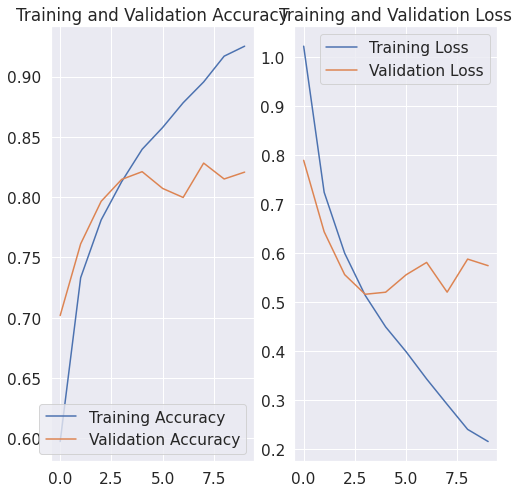

In [ ]:
plot_accuracy_loss(history_10)

## Comparing our models' accuracies so far vol.2

In [ ]:
m6 = max(history_6.history['val_accuracy'])
m7 = max(history_7.history['val_accuracy'])
m8 = max(history_8.history['val_accuracy'])
m10 = max(history_10.history['val_accuracy'])

model_results_2 = [["model_6", m6],
                 ["model_7", m7],
                 ["model_8", m8],
                 ["model_10", m10]]

In [ ]:
# Let's compare our model's results using a pandas DataFrame
all_results_2 = pd.DataFrame(model_results_2, columns=["model", "val_accuracy"])
all_results_2

,model,val_accuracy
0,model_6,0.824011
1,model_7,0.716423
2,model_8,0.817243
3,model_10,0.828286


# Experimenting vol. 3 based on model_10

## BatchNormalization (model_11)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_11 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_11.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [ ]:
history_11 = model_11.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 18s 15ms/step - loss: 0.8486 - accuracy: 0.6799 - val_loss: 1.0529 - val_accuracy: 0.6021
Epoch 2/10
351/351 [==============================] - 4s 12ms/step - loss: 0.5794 - accuracy: 0.7876 - val_loss: 0.7327 - val_accuracy: 0.7410
Epoch 3/10
351/351 [==============================] - 4s 12ms/step - loss: 0.4935 - accuracy: 0.8247 - val_loss: 0.8902 - val_accuracy: 0.6765
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 0.4254 - accuracy: 0.8482 - val_loss: 0.6633 - val_accuracy: 0.7770
Epoch 5/10
351/351 [==============================] - 4s 11ms/step - loss: 0.3807 - accuracy: 0.8602 - val_loss: 0.5202 - val_accuracy: 0.8087
Epoch 6/10
351/351 [==============================] - 4s 11ms/step - loss: 0.3252 - accuracy: 0.8819 - val_loss: 0.7832 - val_accuracy: 0.7410
Epoch 7/10
351/351 [==============================] - 5s 13ms/step - loss: 0.2998 - accuracy: 0.8917 - val_loss: 0.5321 - val_accuracy: 0.814

In [ ]:
model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       1

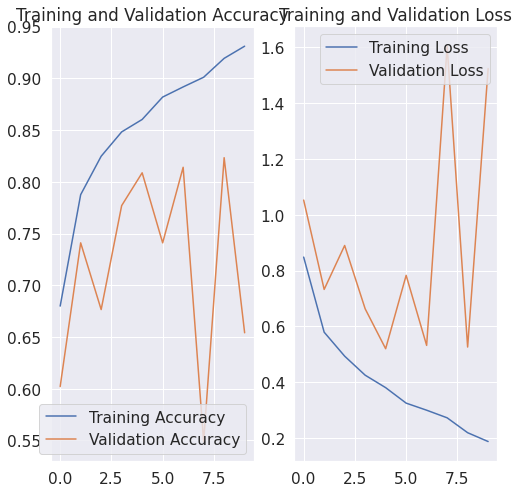

In [ ]:
plot_accuracy_loss(history_11)

## Data augmentation (model_12)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

data_augmentation = Sequential([
  RandomFlip("horizontal", input_shape=INPUT_TENSOR),
  RandomRotation(0.05),
])

#  RandomBrightness(0.1)
#  RandomContrast(0.1),
#  RandomZoom(0.05),

In [ ]:
def display_random_image_and_augmented_image(class_names, images, labels):
    """
        Display a random image and the respective augmented image from the images array and its correspond label from the labels array.
    """

    tf.random.set_seed(42)
    index = np.random.randint(images.shape[0])
    image = images[index]

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

    plt.figure()

    image = tf.cast(tf.expand_dims(image, 0), tf.float32)
    augmented_image = data_augmentation(image)[0]
    plt.imshow(augmented_image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Augmented Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

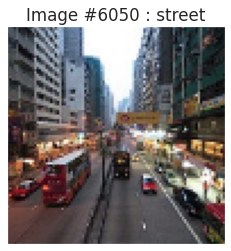

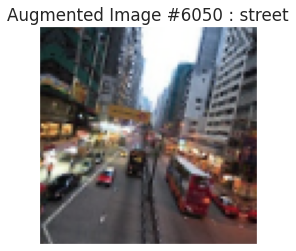

In [ ]:
display_random_image_and_augmented_image(class_names, train_data, train_labels)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_12 = Sequential([
  data_augmentation,
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_12.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [ ]:
history_12 = model_12.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/10


351/351 [==============================] - 30s 75ms/step - loss: 1.1132 - accuracy: 0.5587 - val_loss: 0.9040 - val_accuracy: 0.6377
Epoch 2/10
351/351 [==============================] - 26s 73ms/step - loss: 0.8470 - accuracy: 0.6774 - val_loss: 0.9072 - val_accuracy: 0.6494
Epoch 3/10
351/351 [==============================] - 26s 73ms/step - loss: 0.7436 - accuracy: 0.7289 - val_loss: 0.6956 - val_accuracy: 0.7367
Epoch 4/10
351/351 [==============================] - 26s 73ms/step - loss: 0.6611 - accuracy: 0.7587 - val_loss: 0.6188 - val_accuracy: 0.7855
Epoch 5/10
351/351 [==============================] - 27s 76ms/step - loss: 0.6045 - accuracy: 0.7782 - val_loss: 0.7854 - val_accuracy: 0.7089
Epoch 6/10
351/351 [==============================] - 26s 73ms/step - loss: 0.5524 - accuracy: 0.7996 - val_loss: 0.5981 - val_accuracy: 0.7877
Epoch 7/10
351/351 [==============================] - 26s 74ms/step - loss: 0.5178 - accuracy: 0.8117 - val_loss: 0.6154 - val_accuracy: 0.7734
Epo

You can see each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

In [ ]:
model_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 activation_7 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                      

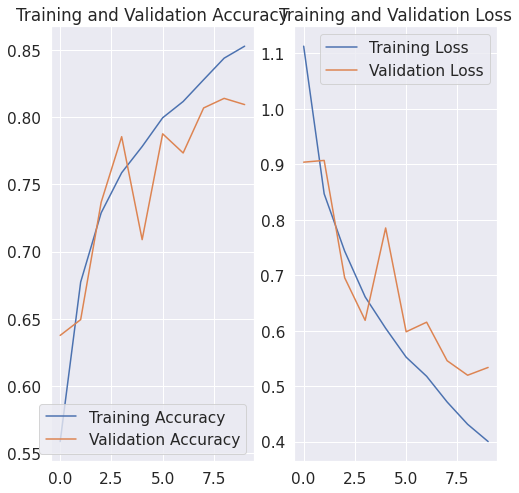

In [ ]:
plot_accuracy_loss(history_12)

That's looking much better, the loss curves are much closer to each other. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

## Dropout (model_13)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_13 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

# Compile the model
model_13.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [ ]:
history_13 = model_13.fit(train_data, train_labels, batch_size=32, epochs=6, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 7s 12ms/step - loss: 1.1849 - accuracy: 0.5251 - val_loss: 1.0525 - val_accuracy: 0.6120
Epoch 2/10
351/351 [==============================] - 4s 10ms/step - loss: 0.8911 - accuracy: 0.6531 - val_loss: 0.9308 - val_accuracy: 0.6669
Epoch 3/10
351/351 [==============================] - 6s 16ms/step - loss: 0.7474 - accuracy: 0.7200 - val_loss: 0.8158 - val_accuracy: 0.7018
Epoch 4/10
351/351 [==============================] - 4s 11ms/step - loss: 0.6591 - accuracy: 0.7565 - val_loss: 0.7343 - val_accuracy: 0.7264
Epoch 5/10
351/351 [==============================] - 4s 11ms/step - loss: 0.5826 - accuracy: 0.7870 - val_loss: 0.7027 - val_accuracy: 0.7496
Epoch 6/10
351/351 [==============================] - 4s 11ms/step - loss: 0.5303 - accuracy: 0.8105 - val_loss: 0.5765 - val_accuracy: 0.7994
Epoch 7/10
351/351 [==============================] - 4s 10ms/step - loss: 0.4991 - accuracy: 0.8179 - val_loss: 0.6644 - val_accuracy: 0.7667

In [ ]:
model_13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 activation_14 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_15 (Activation)  (None, 48, 48, 32)        0         
                                                      

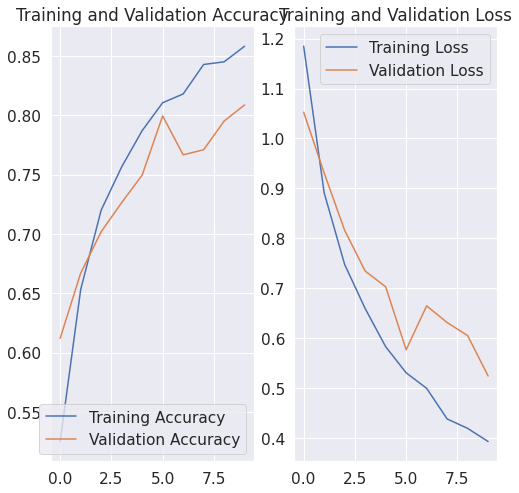

In [ ]:
plot_accuracy_loss(history_13)

## Comparing our models' accuracies so far vol.3

In [ ]:
test_loss_11 = model_11.evaluate(test_data, test_labels)

94/94 [==============================] - 1s 7ms/step - loss: 1.6046 - accuracy: 0.6370


In [ ]:
test_loss_12 = model_12.evaluate(test_data, test_labels)

94/94 [==============================] - 1s 6ms/step - loss: 0.5518 - accuracy: 0.8060


In [ ]:
test_loss_13 = model_13.evaluate(test_data, test_labels)

94/94 [==============================] - 0s 5ms/step - loss: 0.5283 - accuracy: 0.8183


In [ ]:
m11 = max(history_11.history['val_accuracy'])
m12 = max(history_12.history['val_accuracy'])
m13 = max(history_13.history['val_accuracy'])

model_results_3 = [["model_11", test_loss_11[1]],
                 ["model_12", test_loss_12[1]],
                 ["model_13", test_loss_13[1]]]

In [ ]:
# Let's compare our model's results using a pandas DataFrame
all_results_3 = pd.DataFrame(model_results_3, columns=["model", "test_accuracy"])
all_results_3

,model,test_accuracy
0,model_11,0.637000
1,model_12,0.806000
2,model_13,0.818333


# Final model (model_14)

## Training for longer (more epochs)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_14 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(60),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

# Compile the model
model_14.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_14 = model_14.fit(train_data, train_labels, batch_size=32, epochs=18, validation_split = 0.2, callbacks=[model_checkpoint_callback])

Epoch 1/18
241/244 [============================>.] - ETA: 0s - loss: 0.6104 - accuracy: 0.8177
Epoch 1: val_accuracy improved from -inf to 0.99692, saving model to /tmp/checkpoint
244/244 [==============================] - 6s 18ms/step - loss: 0.6044 - accuracy: 0.8195 - val_loss: 0.0187 - val_accuracy: 0.9969
Epoch 2/18
240/244 [============================>.] - ETA: 0s - loss: 0.0400 - accuracy: 0.9883
Epoch 2: val_accuracy improved from 0.99692 to 0.99846, saving model to /tmp/checkpoint
244/244 [==============================] - 2s 10ms/step - loss: 0.0395 - accuracy: 0.9884 - val_loss: 0.0047 - val_accuracy: 0.9985
Epoch 3/18
241/244 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9996
Epoch 3: val_accuracy improved from 0.99846 to 1.00000, saving model to /tmp/checkpoint
244/244 [==============================] - 2s 9ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 7.9727e-04 - val_accuracy: 1.0000
Epoch 4/18
242/244 [============================>.] 

In [ ]:
model_14.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 activation_38 (Activation)  (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 activation_39 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                 

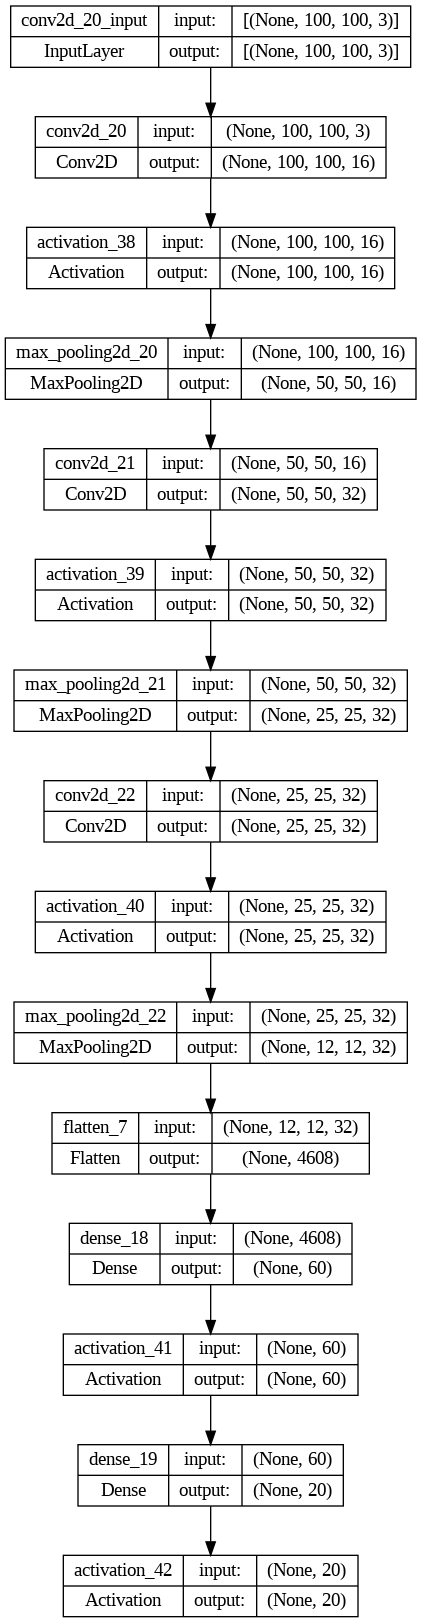

In [ ]:
# Let's check out another way of viewing our deep learning models
# See the inputs and outputs of each layer
plot_model(model_14, show_shapes=True)

In [ ]:
def plot_accuracy_loss_3(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(18)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.xlabel("epochs")
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower left')
  plt.xlabel("epochs")
  plt.title('Training and Validation Loss')
  plt.show()

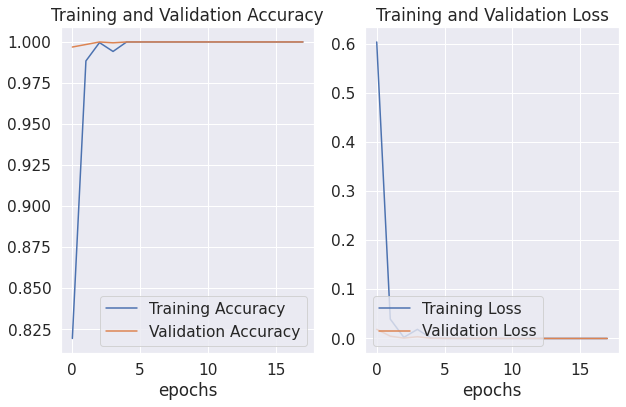

In [ ]:
# Check out model's performance
plot_accuracy_loss_3(history_14)

## Results

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model_14.load_weights(checkpoint_filepath)

In [ ]:
test_loss_14 = model_14.evaluate(test_data, test_labels)

103/103 [==============================] - 1s 6ms/step - loss: 0.0032 - accuracy: 1.0000


103/103 [==============================] - 0s 4ms/step


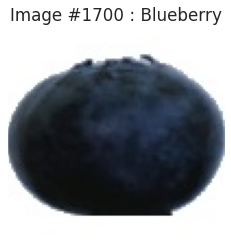

In [ ]:
predictions = model_14.predict(test_data)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_data, pred_labels)

IndexError: ignored

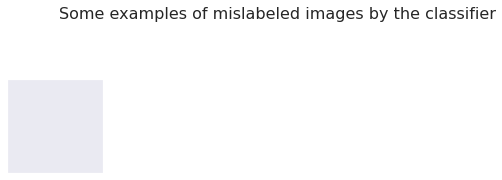

In [ ]:
print_mislabeled_images(class_names, test_data, test_labels, pred_labels)

<ipython-input-6-7aca80be51b6>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if classes!=[]:


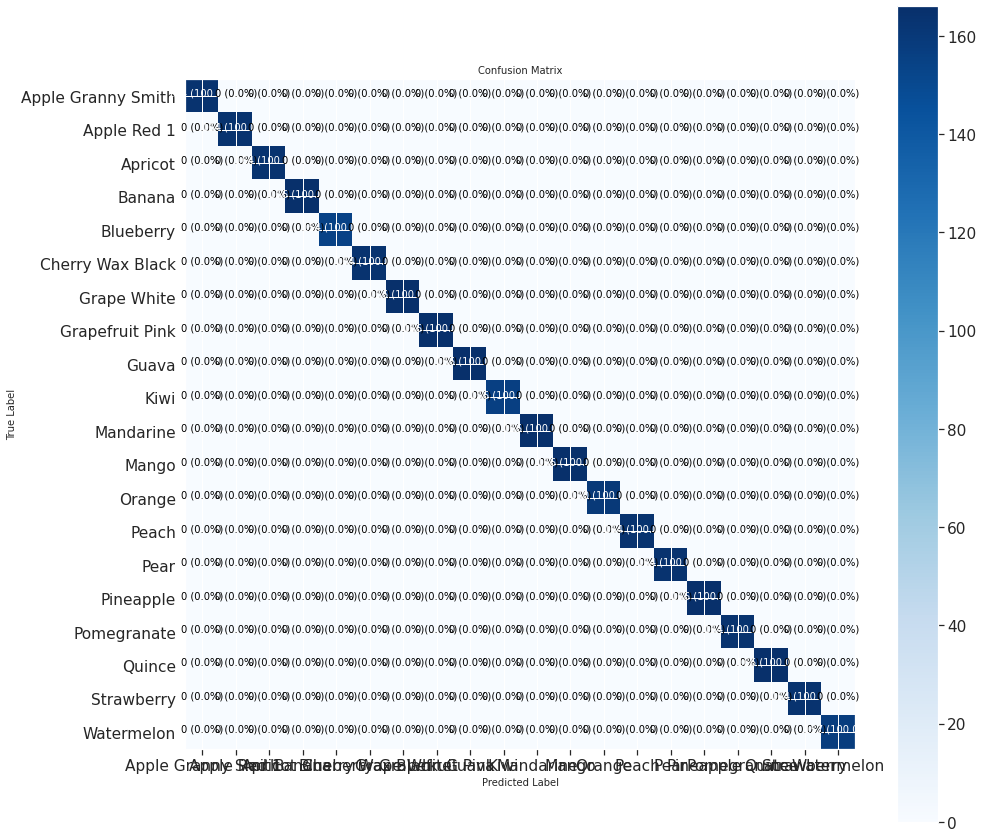

In [ ]:
make_confusion_matrix(y_true=test_labels,
                      y_pred=pred_labels,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

## Saving and loading the best model

### Saving and loading weights of a model

In [ ]:
# Save the weights
model_14.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
new_model = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(60),
  Activation('relu'),
  Dense(20),
  Activation('softmax')
])

new_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Restore the weights
new_model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss, acc = new_model.evaluate(test_data, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

103/103 - 1s - loss: 0.0032 - accuracy: 1.0000 - 626ms/epoch - 6ms/step
Restored model, accuracy: 100.00%


### Saving and loading a model in SavedModel format

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model_14.save("/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/classifier of images for Fruits 360/SavedModel format")

In [ ]:
new_model_2 = tf.keras.models.load_model("/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/classifier of images for Fruits 360/SavedModel format")

# Check its architecture
new_model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 activation_38 (Activation)  (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 activation_39 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                 

In [ ]:
# Evaluate the restored model
loss, acc = new_model_2.evaluate(test_data, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model_2.predict(test_data).shape)

103/103 - 1s - loss: 0.0032 - accuracy: 1.0000 - 864ms/epoch - 8ms/step
Restored model, accuracy: 100.00%
103/103 [==============================] - 0s 4ms/step
(3267, 20)


### Saving and loading a model in HDF5 format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_14.save("/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/classifier of images for Fruits 360/classifier_of_images_for_Fruits_360.h5")

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model_3 = tf.keras.models.load_model("/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/classifier of images for Fruits 360/classifier_of_images_for_Fruits_360.h5")

# Show the model architecture
new_model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 activation_38 (Activation)  (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 activation_39 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                 

In [ ]:
loss, acc = new_model_3.evaluate(test_data, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

103/103 - 1s - loss: 0.0032 - accuracy: 1.0000 - 568ms/epoch - 6ms/step
Restored model, accuracy: 100.00%
